In [1]:
import bagpipes as pipes

In [18]:
# my helper routines
import coepipes
import coeSED

In [4]:
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt
# https://matplotlib.org/tutorials/introductory/customizing.html
#plt.style.use('/Users/dcoe/p/matplotlibrc.txt')
plt.style.use('https://www.stsci.edu/~dcoe/matplotlibrc.txt')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
import matplotlib.ticker as ticker
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [5]:
import numpy as np
from glob import glob
import os
home = os.path.expanduser('~')
from importlib import reload

In [6]:
from PIL import Image, ImageEnhance
import PIL
PIL.Image.MAX_IMAGE_PIXELS = 933120000  # avoid decompression bomb error when loading large images

In [7]:
import astropy.units as u
from astropy.io import ascii
from astropy.io import fits
import astropy.wcs as wcs
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import photutils

In [8]:
field = 'whl0137'

In [10]:
# Color image
#color_image_file = '../color/%s_all8.png' % field
#color_image_file = '../color/%s.png' % field
#color_image_file = os.path.join()
color_image_file = '../color/%s_v4_bright.png' % field
im = Image.open(color_image_file)
color_image = np.asarray(im)
color_image = color_image[::-1]

In [11]:
color_image.shape

(24000, 17600, 3)

In [13]:
indir = '../eazy_v4'

In [14]:
#segm_file = '/Users/dcoe/JWST/ERO/cluster/10/color/hlsp_relics_hst_wfc3ir_smacs0723-73_multi_v1_segm.fits'
#segm_file = '../phot/%s_f200w_detections_segm.fits' % field
#segm_file = 'sunrise-grizli-v2-ir_seg.fits'
#segm_file = os.path.join('../catalogs', segm_file)
segm_file = 'sunrise-grizli-v4.0-ir_20mas_seg.fits.gz'
segm_file = os.path.join(indir, segm_file)
segm_hdu = fits.open(segm_file)[0]
segm_data = segm_hdu.data
segm = photutils.segmentation.SegmentationImage(segm_data)
#imwcs = WCS(segm_hdu.header)

In [15]:
segm_data.shape

(24000, 17600)

In [16]:
hdu = fits.open(segm_file)
idata = 0
image_wcs = wcs.WCS(hdu[idata].header, hdu)

In [19]:
#coeSED.input_flux_units = 'nJy'
#flux_units = u.nJy
coeSED.input_flux_units = 'uJy'
flux_units = u.uJy

In [20]:
# Don't load .ecsv: don't want to deal with units
#infile = '../phot/%s_photometry.cat' % field  # NIRCam catalog pruned
infile = field + '_phot-eazy.cat'
#infile = field + '_highz_sample.ecsv'
infile = os.path.join(indir, infile)
print("Loading", infile)
cat = ascii.read(infile)
cat[:2]

Loading ../eazy_v4/whl0137_phot-eazy.cat


id,ra,dec,f090w_flux,f090w_fluxerr,f105w_flux,f105w_fluxerr,f110w_flux,f110w_fluxerr,f115w_flux,f115w_fluxerr,f125w_flux,f125w_fluxerr,f140w_flux,f140w_fluxerr,f150w_flux,f150w_fluxerr,f160w_flux,f160w_fluxerr,f200w_flux,f200w_fluxerr,f277w_flux,f277w_fluxerr,f356w_flux,f356w_fluxerr,f410m_flux,f410m_fluxerr,f435w_flux,f435w_fluxerr,f444w_flux,f444w_fluxerr,f475w_flux,f475w_fluxerr,f606w_flux,f606w_fluxerr,f814w_flux,f814w_fluxerr,z_spec,nusefilt,z_ml,z_ml_chi2,z_ml_risk,lc_min,lc_max,z_phot,z_phot_chi2,z_phot_risk,z_min_risk,min_risk,z_raw_chi2,raw_chi2,z025,z160,z500,z840,z975,restU,restU_err,restB,restB_err,restV,restV_err,restJ,restJ_err,dL,mass,sfr,Lv,LIR,energy_abs,Lu,Lj,L1400,L2800,LHa,LOIII,LHb,LOII,MLv,Av,lwAgeV,rest120,rest120_err,rest121,rest121_err,rest414,rest414_err,rest415,rest415_err,rest416,rest416_err,flux,peak,flux_radius
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,24.390374,-8.500793,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-1.0,0,-1.0,-1.0,-1.0,43188281021088.9,0.0,-1.0,-1.0,-1.0,0.01,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,-99.0,0.0,-99.0,0.0,-99.0,0.0,-99.0,0.0,0.0,-9e+29,-9e+29,-9e+29,-9e+29,-9e+29,-9e+29,-9e+29,-9e+29,-9e+29,-9e+29,-9e+29,-9e+29,-9e+29,-9e+29,-9e+29,-9e+29,-99.0,0.0,-99.0,0.0,-99.0,0.0,-99.0,0.0,-99.0,0.0,0.02426156584177849,1.3804176471542673e-05,0.0
2,24.379928,-8.500794,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-1.0,0,-1.0,-1.0,-1.0,43188281021088.9,0.0,-1.0,-1.0,-1.0,0.01,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,-99.0,0.0,-99.0,0.0,-99.0,0.0,-99.0,0.0,0.0,-9e+29,-9e+29,-9e+29,-9e+29,-9e+29,-9e+29,-9e+29,-9e+29,-9e+29,-9e+29,-9e+29,-9e+29,-9e+29,-9e+29,-9e+29,-9e+29,-99.0,0.0,-99.0,0.0,-99.0,0.0,-99.0,0.0,-99.0,0.0,0.0027147871291991455,2.9517131549171674e-05,0.0


In [21]:
catalog_coordinates = SkyCoord(ra=cat['ra']*u.deg, dec=cat['dec']*u.deg)  # *u.deg
cat['x'], cat['y'] = image_wcs.world_to_pixel(catalog_coordinates)

In [22]:
cat[:2]

id,ra,dec,f090w_flux,f090w_fluxerr,f105w_flux,f105w_fluxerr,f110w_flux,f110w_fluxerr,f115w_flux,f115w_fluxerr,f125w_flux,f125w_fluxerr,f140w_flux,f140w_fluxerr,f150w_flux,f150w_fluxerr,f160w_flux,f160w_fluxerr,f200w_flux,f200w_fluxerr,f277w_flux,f277w_fluxerr,f356w_flux,f356w_fluxerr,f410m_flux,f410m_fluxerr,f435w_flux,f435w_fluxerr,f444w_flux,f444w_fluxerr,f475w_flux,f475w_fluxerr,f606w_flux,f606w_fluxerr,f814w_flux,f814w_fluxerr,z_spec,nusefilt,z_ml,z_ml_chi2,z_ml_risk,lc_min,lc_max,z_phot,z_phot_chi2,z_phot_risk,z_min_risk,min_risk,z_raw_chi2,raw_chi2,z025,z160,z500,z840,z975,restU,restU_err,restB,restB_err,restV,restV_err,restJ,restJ_err,dL,mass,sfr,Lv,LIR,energy_abs,Lu,Lj,L1400,L2800,LHa,LOIII,LHb,LOII,MLv,Av,lwAgeV,rest120,rest120_err,rest121,rest121_err,rest414,rest414_err,rest415,rest415_err,rest416,rest416_err,flux,peak,flux_radius,x,y
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,24.390374,-8.500793,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-1.0,0,-1.0,-1.0,-1.0,43188281021088.9,0.0,-1.0,-1.0,-1.0,0.01,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,-99.0,0.0,-99.0,0.0,-99.0,0.0,-99.0,0.0,0.0,-9e+29,-9e+29,-9e+29,-9e+29,-9e+29,-9e+29,-9e+29,-9e+29,-9e+29,-9e+29,-9e+29,-9e+29,-9e+29,-9e+29,-9e+29,-9e+29,-99.0,0.0,-99.0,0.0,-99.0,0.0,-99.0,0.0,-99.0,0.0,0.02426156584177849,1.3804176471542673e-05,0.0,844.1299259361213,2.471100395697249
2,24.379928,-8.500794,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-1.0,0,-1.0,-1.0,-1.0,43188281021088.9,0.0,-1.0,-1.0,-1.0,0.01,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,-99.0,0.0,-99.0,0.0,-99.0,0.0,-99.0,0.0,0.0,-9e+29,-9e+29,-9e+29,-9e+29,-9e+29,-9e+29,-9e+29,-9e+29,-9e+29,-9e+29,-9e+29,-9e+29,-9e+29,-9e+29,-9e+29,-9e+29,-99.0,0.0,-99.0,0.0,-99.0,0.0,-99.0,0.0,-99.0,0.0,0.0027147871291991455,2.9517131549171674e-05,0.0,2703.7538846166663,2.435759667030652


In [23]:
#cat.rename_column('label', 'id')
#cat.rename_column('xcentroid', 'x')
#cat.rename_column('ycentroid', 'y')
#for label in list(cat.columns):
#    new_label = label.replace('kron15_tot', '')
#    cat.rename_column(label, new_label)

In [24]:
if 0:
    cat.sort('f200w_flux')
    cat.reverse() # brightest first
    cat[:3]

In [25]:
# not detected: mag =  99; magerr = 1-sigma upper limit assuming zero flux
# not observed: mag = -99; magerr = 0
def fluxes2mags(flux, fluxerr):
    nondet = flux < 0  # Non-detection if flux is negative
    unobs = (fluxerr <= 0) + (fluxerr == np.inf)  # Unobserved if flux uncertainty is negative or infinity

    mag = flux.to(u.ABmag)
    magupperlimit = fluxerr.to(u.ABmag) # 1-sigma upper limit if flux=0

    mag = np.where(nondet, 99 * u.ABmag, mag)
    mag = np.where(unobs, -99 * u.ABmag, mag)

    magerr = 2.5 * np.log10(1 + fluxerr/flux) 
    magerr = magerr.value * u.ABmag

    magerr = np.where(nondet, magupperlimit, magerr)
    magerr = np.where(unobs, 0 * u.ABmag, magerr)
    
    return mag, magerr

In [26]:
# flux -> mag

for label in cat.columns[:]:
    if label.endswith('_flux'):
        if 'det' in label:
            cat.remove_column(label)
        else:
            filt = label.replace('_flux', '')
            flux = cat[label]
            fluxerr = cat[label+'err']
            #flux = flux.to(flux_units).value
            #fluxerr = fluxerr.to(flux_units).value
            nan_flux = np.isnan(flux)
            flux = np.where(nan_flux, 0, flux)
            fluxerr = np.where(nan_flux, 1e30, fluxerr)
            mag, magerr = fluxes2mags(flux * flux_units, fluxerr * flux_units)
            #mag, magerr = fluxes2mags(flux, fluxerr)
            cat[filt+'_flux'] = flux
            cat[filt+'_fluxerr'] = fluxerr
            cat[filt+'_mag'] = mag.value
            cat[filt+'_magerr'] = magerr.value

/Users/dcoe/miniconda3/envs/erophot/lib/python3.10/site-packages/astropy/units/function/logarithmic.py:47: RuntimeWarning: divide by zero encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/Users/dcoe/miniconda3/envs/erophot/lib/python3.10/site-packages/astropy/units/function/logarithmic.py:47: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/Users/dcoe/miniconda3/envs/erophot/lib/python3.10/site-packages/astropy/units/quantity.py:611: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/dcoe/miniconda3/envs/erophot/lib/python3.10/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/dcoe/miniconda3/envs/erophot/lib/python3.10/site-packages/astropy/units/quantity.py:611: RuntimeWarning: divide by zero encou

In [27]:
cat[:2]

id,ra,dec,f090w_flux,f090w_fluxerr,f105w_flux,f105w_fluxerr,f110w_flux,f110w_fluxerr,f115w_flux,f115w_fluxerr,f125w_flux,f125w_fluxerr,f140w_flux,f140w_fluxerr,f150w_flux,f150w_fluxerr,f160w_flux,f160w_fluxerr,f200w_flux,f200w_fluxerr,f277w_flux,f277w_fluxerr,f356w_flux,f356w_fluxerr,f410m_flux,f410m_fluxerr,f435w_flux,f435w_fluxerr,f444w_flux,f444w_fluxerr,f475w_flux,f475w_fluxerr,f606w_flux,f606w_fluxerr,f814w_flux,f814w_fluxerr,z_spec,nusefilt,z_ml,z_ml_chi2,z_ml_risk,lc_min,lc_max,z_phot,z_phot_chi2,z_phot_risk,z_min_risk,min_risk,z_raw_chi2,raw_chi2,z025,z160,z500,z840,z975,restU,restU_err,restB,restB_err,restV,restV_err,restJ,restJ_err,dL,mass,sfr,Lv,LIR,energy_abs,Lu,Lj,L1400,L2800,LHa,LOIII,LHb,LOII,MLv,Av,lwAgeV,rest120,rest120_err,rest121,rest121_err,rest414,rest414_err,rest415,rest415_err,rest416,rest416_err,flux,peak,flux_radius,x,y,f090w_mag,f090w_magerr,f105w_mag,f105w_magerr,f110w_mag,f110w_magerr,f115w_mag,f115w_magerr,f125w_mag,f125w_magerr,f140w_mag,f140w_magerr,f150w_mag,f150w_magerr,f160w_mag,f160w_magerr,f200w_mag,f200w_magerr,f277w_mag,f277w_magerr,f356w_mag,f356w_magerr,f410m_mag,f410m_magerr,f435w_mag,f435w_magerr,f444w_mag,f444w_magerr,f475w_mag,f475w_magerr,f606w_mag,f606w_magerr,f814w_mag,f814w_magerr
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,24.390374,-8.500793,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-1.0,0,-1.0,-1.0,-1.0,43188281021088.9,0.0,-1.0,-1.0,-1.0,0.01,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,-99.0,0.0,-99.0,0.0,-99.0,0.0,-99.0,0.0,0.0,-9e+29,-9e+29,-9e+29,-9e+29,-9e+29,-9e+29,-9e+29,-9e+29,-9e+29,-9e+29,-9e+29,-9e+29,-9e+29,-9e+29,-9e+29,-9e+29,-99.0,0.0,-99.0,0.0,-99.0,0.0,-99.0,0.0,-99.0,0.0,0.02426156584177849,1.3804176471542673e-05,0.0,844.1299259361213,2.471100395697249,-99.0,0.0,-99.0,0.0,-99.0,0.0,-99.0,0.0,-99.0,0.0,-99.0,0.0,-99.0,0.0,-99.0,0.0,-99.0,0.0,-99.0,0.0,-99.0,0.0,-99.0,0.0,-99.0,0.0,-99.0,0.0,-99.0,0.0,-99.0,0.0,-99.0,0.0
2,24.379928,-8.500794,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-1.0,0,-1.0,-1.0,-1.0,43188281021088.9,0.0,-1.0,-1.0,-1.0,0.01,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,-99.0,0.0,-99.0,0.0,-99.0,0.0,-99.0,0.0,0.0,-9e+29,-9e+29,-9e+29,-9e+29,-9e+29,-9e+29,-9e+29,-9e+29,-9e+29,-9e+29,-9e+29,-9e+29,-9e+29,-9e+29,-9e+29,-9e+29,-99.0,0.0,-99.0,0.0,-99.0,0.0,-99.0,0.0,-99.0,0.0,0.0027147871291991455,2.9517131549171674e-05,0.0,2703.7538846166663,2.435759667030652,-99.0,0.0,-99.0,0.0,-99.0,0.0,-99.0,0.0,-99.0,0.0,-99.0,0.0,-99.0,0.0,-99.0,0.0,-99.0,0.0,-99.0,0.0,-99.0,0.0,-99.0,0.0,-99.0,0.0,-99.0,0.0,-99.0,0.0,-99.0,0.0,-99.0,0.0


In [28]:
filters = coeSED.extract_filters(cat)
#filt_list = list(map(coeSED.getfullfiltfile, filters))  # only works for HST
filt_list = list(map(coepipes.get_full_filter_name, filters))
filt_lams = list(map(coeSED.getlam, filters))
coeSED.cat = cat
coeSED.filters = filters
filters

['f090w',
 'f105w',
 'f110w',
 'f115w',
 'f125w',
 'f140w',
 'f150w',
 'f160w',
 'f200w',
 'f277w',
 'f356w',
 'f410m',
 'f435w',
 'f444w',
 'f475w',
 'f606w',
 'f814w']

In [29]:
filt_list

['FILTER/JWST_NIRCAM_F090W.res',
 'FILTER/HST_WFC3_IR_F105W.res',
 'FILTER/HST_WFC3_IR_F110W.res',
 'FILTER/JWST_NIRCAM_F115W.res',
 'FILTER/HST_WFC3_IR_F125W.res',
 'FILTER/HST_WFC3_IR_F140W.res',
 'FILTER/JWST_NIRCAM_F150W.res',
 'FILTER/HST_WFC3_IR_F160W.res',
 'FILTER/JWST_NIRCAM_F200W.res',
 'FILTER/JWST_NIRCAM_F277W.res',
 'FILTER/JWST_NIRCAM_F356W.res',
 'FILTER/JWST_NIRCAM_F410M.res',
 'FILTER/HST_ACS_WFC_F435W.res',
 'FILTER/JWST_NIRCAM_F444W.res',
 'FILTER/HST_ACS_WFC_F475W.res',
 'FILTER/HST_ACS_WFC_F606W.res',
 'FILTER/HST_ACS_WFC_F814W.res']

In [30]:
#coepipes.get_full_filter_name('F090W')

In [31]:
#id = cat['id'][0]
id = 1686  # HST-dark galaxy
id

1686

In [32]:
coeSED.load_phot(id)  # uJy

array([[-1.900e-02,  2.300e-02],
       [ 6.300e-02,  7.800e-02],
       [ 1.470e-01,  1.600e-02],
       [ 1.900e-01,  2.300e-02],
       [ 1.690e-01,  1.420e-01],
       [ 2.320e-01,  1.200e-01],
       [ 2.750e-01,  2.000e-02],
       [ 3.310e-01,  8.400e-02],
       [ 6.570e-01,  1.600e-02],
       [ 1.802e+00,  1.600e-02],
       [ 2.987e+00,  1.700e-02],
       [ 4.536e+00,  3.000e-02],
       [ 5.900e-02,  6.200e-02],
       [ 5.981e+00,  2.600e-02],
       [-6.100e-02,  3.200e-02],
       [ 3.000e-03,  3.700e-02],
       [ 5.500e-02,  2.300e-02]])

In [ ]:
# https://bagpipes.readthedocs.io/en/stable/model_galaxies.html

# Fit all the galaxies with fewer parameters

fit_instructions = {}                   # The model components dictionary
fit_instructions["redshift"] = 0, 16
fit_instructions["nebular"] = {'logU':-2}  # {"logU":(-4,-2)}  # log_10(ionization parameter) # I added log(U) = -1; not there by default

dust = {"type":"Calzetti"} # Calzetti
dust["Av"] = 0, 3  # magnitudes
dust["eta"] = 2    # Extra dust for young stars: multiplies Av
fit_instructions["dust"] = dust
fit_instructions["t_bc"] = 0.01         # Lifetime of birth clouds (Gyr)

sfh = {} # Star Formation History
sfh['massformed'] = 0, 13  # log_10(mass formed)
sfh['metallicity'] = 0.4  # Z / Zsun; middle model
#sfh['metallicity'] = 0.005, 5  # Z / Zsun; allowed range of mdoels
#sfh['metallicity_prior'] = 'log_10'
sfh['age'] = 0.001, 15         # Gyr: Time since star formation began (capped at age of universe)
sfh['tau'] = (0.001, 10.)  # Vary tau between 1 Myr and 10 Gyr
fit_instructions["delayed"] = sfh  # **delayed** SFH ~ t * exp(-t / tau)
run_id = 'delayed-tau_zphot_dust0-3'
# run_id = 'delayed-tau_zphot' # dust 0-5

print(run_id)
fit_instructions

In [33]:
# https://bagpipes.readthedocs.io/en/stable/model_galaxies.html

# Fit individual galaxies allowing more freedom in parameter space

fit_instructions = {}                   # The model components dictionary
fit_instructions["redshift"] = 0, 20  # note I set max 20 in BAGPIPES code
fit_instructions["nebular"] = {"logU":(-4,-2)}  # log_10(ionization parameter) # I added log(U) = -1; not there by default

dust = {"type":"Calzetti"} # Calzetti
dust["Av"] = 0, 5  # magnitudes
dust["eta"] = 2    # Extra dust for young stars: multiplies Av
fit_instructions["dust"] = dust
fit_instructions["t_bc"] = 0.01         # Lifetime of birth clouds (Gyr)

sfh = {} # Star Formation History
sfh['massformed'] = 0, 13  # log_10(mass formed)
sfh['metallicity'] = 0.005, 5  # Z / Zsun; allowed range of mdoels
sfh['metallicity_prior'] = 'log_10'
sfh['age'] = 0.001, 15         # Gyr: Time since star formation began (capped at age of universe)
sfh['tau'] = (0.001, 10.)  # Vary tau between 1 Myr and 10 Gyr
fit_instructions["delayed"] = sfh  # **delayed** SFH ~ t * exp(-t / tau)
run_id = 'delayed-tau_dust5_Zall'

print(run_id)
fit_instructions

delayed-tau_dust5_Zall


{'redshift': (0, 20),
 'nebular': {'logU': (-4, -2)},
 'dust': {'type': 'Calzetti', 'Av': (0, 5), 'eta': 2},
 't_bc': 0.01,
 'delayed': {'massformed': (0, 13),
  'metallicity': (0.005, 5),
  'metallicity_prior': 'log_10',
  'age': (0.001, 15),
  'tau': (0.001, 10.0)}}

In [34]:
def load_results(run_id, id, all_samples=True):
    print(id)
    print(run_id)
    observed_galaxy = pipes.galaxy(id, coeSED.load_phot, filt_list=filt_list, spectrum_exists=False)    
    #fit_instructions = coepipes.set_fit_instructions(run_id)
    #set_model_type(run_id)
    if all_samples:
        fit = pipes.fit(observed_galaxy, fit_instructions, run=run_id, n_posterior=np.inf)  # all the samples, not just 500
    else:
        fit = pipes.fit(observed_galaxy, fit_instructions, run=run_id)  # just 500 samples by default
    fit.fit(verbose=True)
    fit.posterior.get_advanced_quantities()  # posterior.model_galaxy
    return fit

In [ ]:
def load_phot_sum(id):
    phot = add_fluxes(ids)
    return(phot)

In [ ]:
def load_results_sum(run_id, id):
    print(id)
    print(run_id)
    observed_galaxy = pipes.galaxy(id, load_phot_sum, filt_list=filt_list, spectrum_exists=False)    
    #fit_instructions = coepipes.set_fit_instructions(run_id)
    #set_model_type(run_id)
    fit = pipes.fit(observed_galaxy, fit_instructions, run=run_id, n_posterior=np.inf)  # all the samples, not just 500
    fit.fit(verbose=True)
    fit.posterior.get_advanced_quantities()  # posterior.model_galaxy
    return fit

In [35]:
#%matplotlib inline
%matplotlib notebook
#reload(coeETC)

In [36]:
def roundint(x):
    return int(np.round(x))

def slices_extent(x, y, dx, dy=0):
    dy = dy or dx
    xlo = roundint(x-dx)
    xhi = roundint(x+dx+1)
    ylo = roundint(y-dy)
    yhi = roundint(y+dy+1)
    xslice = slice(xlo, xhi)
    yslice = slice(ylo, yhi)
    slices = yslice, xslice
    extent = xlo, xhi, ylo, yhi
    return slices, extent

In [37]:
# Show color image and segment
def show_galaxy_stamp(id):
    global obj, xlo, xhi, ylo, yhi, cmap
    obj = coeSED.extract_id(cat, id)
    x = obj['x'] #* 2  # 40mas -> 20mas
    y = obj['y'] #* 2  # 40mas -> 20mas
    dx = dy = 100 * 2
    #xlo, xhi, ylo, yhi = x-dx, x+dx, y-dy, y+dy
    slices, extent = slices_extent(x, y, dx, dy)

    fig = plt.figure(figsize=(10, 5))
    ax1 = fig.add_subplot(1,1,1)
    ax1.imshow(color_image[slices], extent=extent)
    plt.xlabel('')
    plt.ylabel('')
    ax1.axes.xaxis.set_visible(False)
    ax1.axes.yaxis.set_visible(False)
    fig.tight_layout()
    
    return fig

In [38]:
#id = cat['id'][0]
#id = 677 # Sunrise Arc
id

1686

<IPython.core.display.Javascript object>


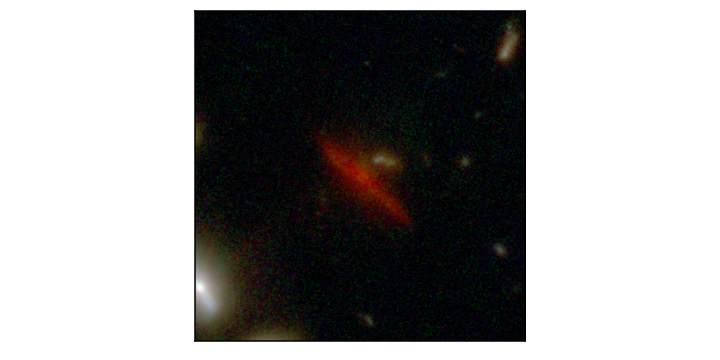

In [39]:
show_galaxy_stamp(id);

In [ ]:
#coeSED.load_phot(id)

In [40]:
fit = load_results(run_id, id)  # ~2 minutes

1686
delayed-tau_dust5_Zall

Bagpipes: fitting object 1686

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    7
 *****************************************************
 Starting MultiNest
 generating live points
 live points generated, starting sampling
Acceptance Rate:                        0.495595
Replacements:                                450
Total Samples:                               908
Nested Sampling ln(Z):            **************
Acceptance Rate:                        0.329815
Replacements:                                500
Total Samples:                              1516
Nested Sampling ln(Z):            **************
Acceptance Rate:                        0.285418
Replacements:                                550
Total Samples:                              1927
Nested Sampling l

Acceptance Rate:                        0.143485
Replacements:                               2450
Total Samples:                             17075
Nested Sampling ln(Z):             -11114.992153
Acceptance Rate:                        0.143316
Replacements:                               2500
Total Samples:                             17444
Nested Sampling ln(Z):              -9780.596698
Acceptance Rate:                        0.143025
Replacements:                               2550
Total Samples:                             17829
Nested Sampling ln(Z):              -8358.074326
Acceptance Rate:                        0.141581
Replacements:                               2600
Total Samples:                             18364
Nested Sampling ln(Z):              -7356.370385
Acceptance Rate:                        0.141070
Replacements:                               2650
Total Samples:                             18785
Nested Sampling ln(Z):              -6533.766211
Acceptance Rate:    

Acceptance Rate:                        0.090124
Replacements:                               4550
Total Samples:                             50486
Nested Sampling ln(Z):                234.831904
Acceptance Rate:                        0.089437
Replacements:                               4600
Total Samples:                             51433
Nested Sampling ln(Z):                261.538576
Acceptance Rate:                        0.088637
Replacements:                               4650
Total Samples:                             52461
Nested Sampling ln(Z):                279.753031

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.
Acceptance Rate:                        0.088200
Replacements:                               4700
Total Samples:                             53288
Nested Sampling ln(Z):                296.362607
Acceptance Rate:                        0.087234
Replacements:                               4750
Total

Acceptance Rate:                        0.045815
Replacements:                               9242
Total Samples:                            201724
Nested Sampling ln(Z):                715.396594
Acceptance Rate:                        0.045276
Replacements:                               9392
Total Samples:                            207439
Nested Sampling ln(Z):                716.809818
Acceptance Rate:                        0.044999
Replacements:                               9543
Total Samples:                            212073
Nested Sampling ln(Z):                718.094478
Acceptance Rate:                        0.044712
Replacements:                               9743
Total Samples:                            217906
Nested Sampling ln(Z):                719.452976
Acceptance Rate:                        0.044476
Replacements:                               9943
Total Samples:                            223558
Nested Sampling ln(Z):                720.543767
Acceptance Rate:    

In [41]:
calc_EWs = ['OIII+Hbeta']
coepipes.save_results(fit, run_id, id, calc_EWs=calc_EWs) # load ALL samples and save ASCII output

Calculating Equivalent Widths for OIII+Hbeta...
Done: max EW = 238 A
redshift
stellar_mass
sfr
ssfr
delayed:age
formation_time
delayed:tau
mass_weighted_age
tform
delayed:metallicity
dust:Av
dust:eta not in fit keys; skipping...
nebular:logU
chisq_phot
EW_OIII+Hbeta
SAVING pipes/cats/delayed-tau_dust5_Zall/1686.cat


<IPython.core.display.Javascript object>


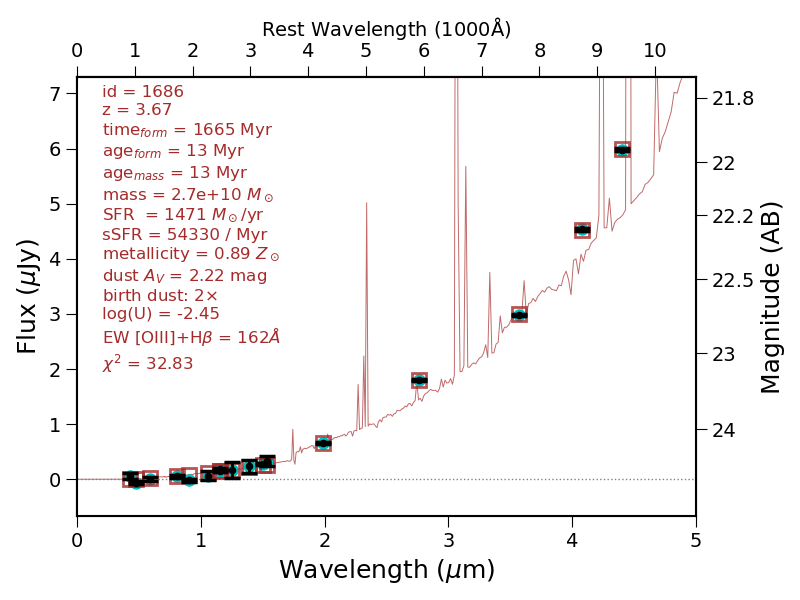

z= 3.6687540709972617 ; age of the universe = 1.6789946821141584 Gyr
SAVING pipes/plots/delayed-tau_dust5_Zall/bagpipes_sed_1686.png


In [42]:
reload(coepipes)
plt1, fig1, ax1, secax = coepipes.plot_SED(fit, id, choice='best', flux_units=flux_units, 
                                           plot_title=False, fontsize=12, save_plot=True)

<IPython.core.display.Javascript object>


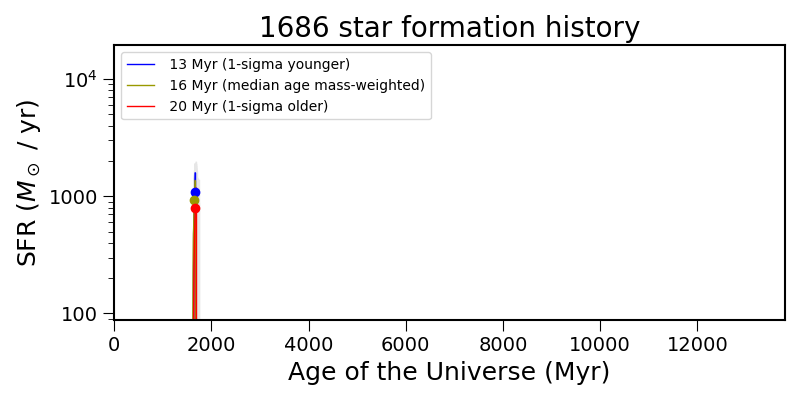

SAVING pipes/plots/delayed-tau_dust5_Zall/bagpipes_sfh-tuniv_1686.png


<IPython.core.display.Javascript object>


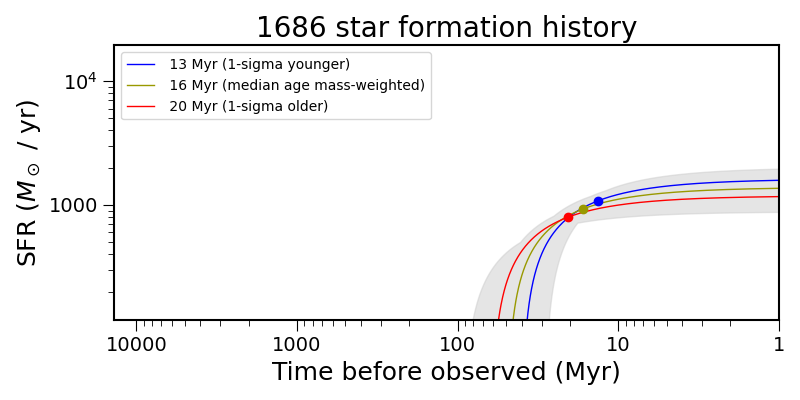

SAVING pipes/plots/delayed-tau_dust5_Zall/bagpipes_sfh-tago_1686.png


In [43]:
reload(coepipes)
fig = coepipes.plot_sfh(fit, id, plot_tuniv=True,  save_plot=True)
fig = coepipes.plot_sfh(fit, id, plot_tuniv=False, save_plot=True)

In [ ]:
#ids = 677, 678, 679, 783, 784, 785, 849, 850, 851
for id in []: # ids[1:]:  # already did first one above
    fit = load_results(run_id, id)  # ~2 minutes
    coepipes.save_results(fit, run_id, id, calc_EWs=calc_EWs) # load ALL samples and save ASCII output
    plt1, fig1, ax1, secax = coepipes.plot_SED(fit, id, choice='best', flux_units=flux_units, 
                                           plot_title=False, fontsize=12, save_plot=True)
    fig = coepipes.plot_sfh(fit, id, plot_tuniv=True,  save_plot=True)
    fig = coepipes.plot_sfh(fit, id, plot_tuniv=False, save_plot=True)

# Run the rest of the galaxies and save results

# Save cards showing all results for each galaxy

In [44]:
# Show color image and segment
def show_galaxy(id):
    global obj, xlo, xhi, ylo, yhi, cmap
    obj = coeSED.extract_id(cat, id)
    x = obj['x']
    y = obj['y']
    dx = dy = 100
    xlo, xhi, ylo, yhi = x-dx, x+dx, y-dy, y+dy
    cmap = segm.make_cmap(seed=12345)
    cmap_colors = cmap.colors[:]
    cmap_colors[0]  = np.array([1, 1, 1])  # white background
    cmap_colors[id] = np.array([0, 0, 0])  # black selected object
    cmap = ListedColormap(cmap_colors)

    fig = plt.figure(figsize=(10, 5))
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(color_image)
    plt.xlim(xlo, xhi)
    plt.ylim(ylo, yhi)
    plt.xlabel('')
    plt.ylabel('')
    ax1.axes.xaxis.set_visible(False)
    ax1.axes.yaxis.set_visible(False)

    ax2 = fig.add_subplot(1,2,2)
    plt.imshow(segm_data, cmap=cmap)
    plt.xlim(xlo, xhi)
    plt.ylim(ylo, yhi)
    plt.xlabel('')
    plt.ylabel('')
    ax2.axes.xaxis.set_visible(False)
    ax2.axes.yaxis.set_visible(False)
    fig.tight_layout()
    
    return fig

In [67]:
# Show color image and segment
def show_galaxy(id):
    global obj, xlo, xhi, ylo, yhi, cmap
    obj = coeSED.extract_id(cat, id)
    x = obj['x']
    y = obj['y']
    dx = dy = 100
    #xlo, xhi, ylo, yhi = x-dx, x+dx, y-dy, y+dy
    slices, extent = slices_extent(x, y, dx, dy)
    xlo, xhi, ylo, yhi = extent
    cmap = segm.make_cmap(seed=12345)
    cmap_colors = cmap.colors[:]
    cmap_colors[0]  = np.array([1, 1, 1])  # white background
    cmap_colors[id] = np.array([0, 0, 0])  # black selected object
    cmap = ListedColormap(cmap_colors)

    fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
    
    #ax[0].imshow(imrgb)
    ax[0].imshow(color_image[slices], extent=extent)
    #ax[0].set_xlim(xlo, xhi)
    #ax[0].set_ylim(ylo, yhi)
    ax[0].set_xlabel('')
    ax[0].set_ylabel('')
    ax[0].axes.xaxis.set_visible(False)
    ax[0].axes.yaxis.set_visible(False)

    ax[1].imshow(segm_data, cmap=cmap, interpolation='none')
    ax[1].set_xlim(xlo, xhi)
    ax[1].set_ylim(ylo, yhi)
    ax[1].set_xlabel('')
    ax[1].set_ylabel('')
    ax[1].axes.xaxis.set_visible(False)
    ax[1].axes.yaxis.set_visible(False)
    fig.tight_layout()

In [68]:
# Show color image and segment
def show_segments(ids):
    global obj, xlo, xhi, ylo, yhi, cmap
    cmap = segm.make_cmap(seed=12345)
    cmap_colors = cmap.colors[:]
    cmap_colors[0]  = np.array([1, 1, 1])  # white background

    xlo = ylo = 1e99
    xhi = yhi = 0
    for id in ids:
        obj = coeSED.extract_id(cat, id)
        x = obj['x']
        y = obj['y']
        dx = dy = 100
        #xlo, xhi, ylo, yhi = x-dx, x+dx, y-dy, y+dy
        slices, extent = slices_extent(x, y, dx, dy)
        #yslice, xslice = slices
        xlo, xhi, ylo, yhi = extent
        xlo = np.min([xlo, x-dx])
        xhi = np.max([xhi, x+dx])
        ylo = np.min([ylo, y-dy])
        yhi = np.max([yhi, y+dy])
        cmap_colors[id] = np.array([0, 0, 0])  # black selected object

    cmap = ListedColormap(cmap_colors)

    fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
    
    ax[0].imshow(color_image[slices], extent=extent)
    #ax[0].set_xlim(xlo, xhi)
    #ax[0].set_ylim(ylo, yhi)
    ax[0].set_xlabel('')
    ax[0].set_ylabel('')
    ax[0].axes.xaxis.set_visible(False)
    ax[0].axes.yaxis.set_visible(False)

    ax[1].imshow(segm_data, cmap=cmap, interpolation='none')
    ax[1].set_xlim(xlo, xhi)
    ax[1].set_ylim(ylo, yhi)
    ax[1].set_xlabel('')
    ax[1].set_ylabel('')
    ax[1].axes.xaxis.set_visible(False)
    ax[1].axes.yaxis.set_visible(False)
    fig.tight_layout()

In [69]:
imrgb = color_image

<IPython.core.display.Javascript object>


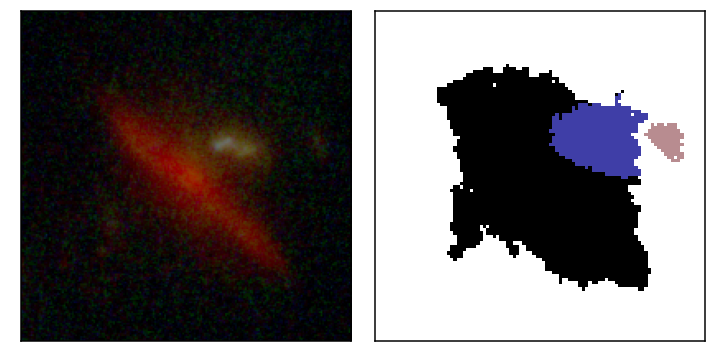

In [70]:
show_galaxy(id)

In [ ]:
def hypotn(x):
    return np.sqrt(np.sum(x**2, axis=0))

def add_fluxes(ids):
    all_fluxes = []
    all_fluxerrs = []
    for id in ids:
        fluxes, fluxerrs = coeSED.load_phot(id).T
        all_fluxes.append(fluxes)
        all_fluxerrs.append(fluxerrs)

    all_fluxes = np.array(all_fluxes)
    all_fluxerrs = np.array(all_fluxerrs)
    
    flux_sum = np.sum(all_fluxes, axis=0)
    fluxerr_sum = hypotn(all_fluxerrs)
    photometry = np.c_[flux_sum, fluxerr_sum]
    return photometry

In [49]:
# Plot log(1+z)

def z2log(z):
    return np.log10(1+z)

def log2z(log1z):
    return 10 ** log1z - 1

In [71]:
def plot_galaxy_results(fit, id):
    global obj, xlo, xhi, ylo, yhi, cmap
    obj = coeSED.extract_id(cat, id)
    x = obj['x']
    y = obj['y']
    dx = dy = 100
    xlo, xhi, ylo, yhi = x-dx, x+dx, y-dy, y+dy
    slices, extent = slices_extent(x, y, dx, dy)
    cmap = segm.make_cmap(seed=12345)
    cmap_colors = cmap.colors[:]
    cmap_colors[0]  = np.array([1, 1, 1])  # white background
    cmap_colors[id] = np.array([0, 0, 0])  # black selected object
    cmap = ListedColormap(cmap_colors)

    fig = plt.figure(figsize=(12, 6))
    gs = fig.add_gridspec(3, 6, wspace=0)  # nrows, ncolumns

    #ax1 = fig.add_subplot(3,6,1)  # nrows, ncolumns, index
    ax1 = fig.add_subplot(gs[0,0])
    ax1.imshow(color_image[slices], extent=extent)
    plt.xlim(xlo, xhi)
    plt.ylim(ylo, yhi)
    ax1.axes.xaxis.set_visible(False)
    ax1.axes.yaxis.set_visible(False)

    #ax2 = fig.add_subplot(3,6,2)  # nrows, ncolumns, index
    ax2 = fig.add_subplot(gs[0,1])
    plt.imshow(segm_data, cmap=cmap, interpolation='none')
    plt.xlim(xlo, xhi)
    plt.ylim(ylo, yhi)
    ax2.axes.xaxis.set_visible(False)
    ax2.axes.yaxis.set_visible(False)

    gs3 = fig.add_gridspec(100, 3, wspace=0.3)  # nrows, ncolumns

    if 0:
        ax3 = fig.add_subplot(gs3[45:50,0])
        plt.hist(fit.posterior.samples['redshift'], ec=colors[0], lw=3)
        plt.xlim(0, fit_instructions["redshift"][1])
        ax3.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax3.xaxis.tick_top()
        ax3.axes.yaxis.set_visible(False)
        ax3.set_title('Redshift', fontsize=16)
    try:
        ax3 = fig.add_subplot(gs3[45:50,0])
        plt.hist(z2log(fit.posterior.samples['redshift']), bins=50, ec=colors[0], lw=3)

        #ztx = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 13, 16, 20, 25]
        #ztx = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 13, 16, 20, 25]
        #ztx = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 14, 19, 25]
        zmax = fit_instructions["redshift"][1]
        ztx = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 15, 20]
        #ztx_minor = 0.2, 0.4, 0.6, 0.8, 9, 11, 12, 13
        ztx_minor = np.arange(0.2,1,0.2)
        ztx_minor = set(ztx_minor) | set(np.arange(zmax)).difference(ztx)
        ztx_minor = list(ztx_minor)
        plt.xlim(0, z2log(zmax))

        #ax3.xaxis.tick_bottom()
        plt.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
        plt.tick_params(axis='y', which='both', left=False, labelleft=False)
        sec_xax = ax3.secondary_xaxis('top', functions=(log2z, z2log))
        sec_xax.set_xticks(ztx)
        sec_xax.set_xticks(ztx_minor, minor=True)
        sec_xax.set_xlabel('Redshift', fontsize=16)        
    except:  # maybe fixed redshift
        pass

    ax3b = fig.add_subplot(gs3[70:75,0])
    log_sSFR_Myr = fit.posterior.samples['ssfr'] + 12
    log_sSFR_Myr = log_sSFR_Myr[np.isfinite(log_sSFR_Myr)]
    plt.hist(log_sSFR_Myr, ec=colors[0], lw=3)
    plt.xlim(0,5)
    ax3b.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax3b.xaxis.tick_top()
    ax3b.axes.yaxis.set_visible(False)
    #ax3b.set_title('log sSFR ( / Myr)', fontsize=16)
    ax3b.set_title('log sSFR (Myr$^{-1}$)', fontsize=16)

    ax3c = fig.add_subplot(gs3[95:100, 0])
    plt.hist(fit.posterior.samples['dust:Av'], ec=colors[0], lw=3)
    plt.xlim(dust["Av"][0], dust["Av"][1])
    ax3c.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax3c.xaxis.tick_top()
    ax3c.axes.yaxis.set_visible(False)
    ax3c.set_title('dust $A_V$ (mag)', fontsize=16)

    gs4 = fig.add_gridspec(1, 3)  # nrows, ncolumns
    ax4 = fig.add_subplot(gs4[0,1:])
    plt1, fig1, ax1, secax = coepipes.plot_SED(fit, id, choice='best', flux_units=u.uJy, input_figax=(fig,ax4), 
                                               plot_title=False, fontsize=12)
    
    return fig

In [51]:
def plot_galaxy_redshift(fit, id):
    global obj, xlo, xhi, ylo, yhi, cmap
    obj = coeSED.extract_id(cat, id)
    x = obj['x']
    y = obj['y']
    dx = dy = 100
    xlo, xhi, ylo, yhi = x-dx, x+dx, y-dy, y+dy
    cmap = segm.make_cmap(seed=12345)
    cmap_colors = cmap.colors[:]
    cmap_colors[0]  = np.array([1, 1, 1])  # white background
    cmap_colors[id] = np.array([0, 0, 0])  # black selected object
    cmap = ListedColormap(cmap_colors)

    fig = plt.figure(figsize=(12, 6))
    gs = fig.add_gridspec(3, 6, wspace=0)  # nrows, ncolumns

    gs3 = fig.add_gridspec(100, 3, wspace=0.3)  # nrows, ncolumns

    ax3 = fig.add_subplot(gs3[45:50,0])
    plt.hist(z2log(fit.posterior.samples['redshift']), bins=50, ec=colors[0], lw=3)
    zmax = fit_instructions["redshift"][1]
    ztx = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 13, 16, 20]
    ztx_minor = np.arange(0.2,1,0.2)
    ztx_minor = set(ztx_minor) | set(np.arange(zmax)).difference(ztx)
    ztx_minor = list(ztx_minor)
    plt.xlim(0, z2log(zmax))

    #ax3.xaxis.tick_bottom()
    plt.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    plt.tick_params(axis='y', which='both', left=False, labelleft=False)
    sec_xax = ax3.secondary_xaxis('top', functions=(log2z, z2log))
    sec_xax.set_xticks(ztx)
    sec_xax.set_xticks(ztx_minor, minor=True)
    sec_xax.set_xlabel('Redshift', fontsize=16)        

    return fig

In [ ]:
for id in []:
    fit = load_results(run_id, id)  # ~2 minutes
    fig = plot_galaxy_results(fit, id)

    plot_file = fit.fname.replace('posterior/', 'plots/')
    plot_file = os.path.dirname(plot_file)
    plot_file = os.path.join(plot_file, 'bagpipes_%d.png' % id)
    print('SAVING', plot_file)
    fig.savefig(plot_file, dpi=100)

In [ ]:
#reload(coepipes)
#plt1, fig1, ax1, secax = coepipes.plot_SED(fit, id, choice='best', flux_units=u.uJy, plot_title=False, fontsize=12)
                                          #plot_full_spec=0.95)

<IPython.core.display.Javascript object>


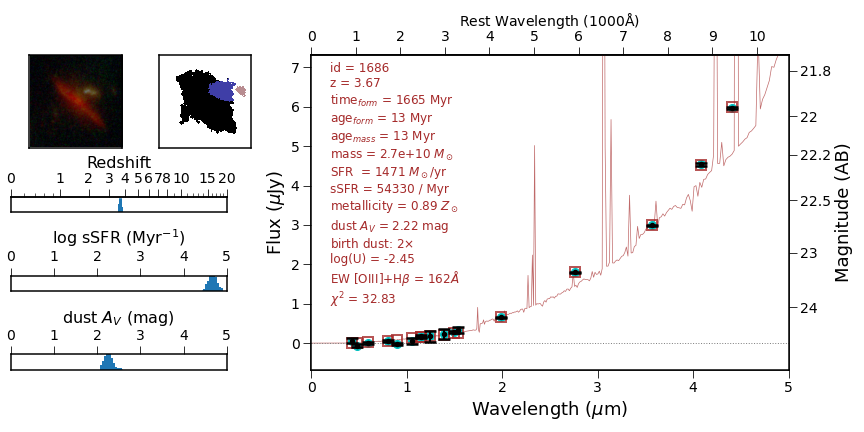

z= 3.6687540709972617 ; age of the universe = 1.6789946821141584 Gyr


In [72]:
fig = plot_galaxy_results(fit, id)

In [ ]:
#plt.close('all')